In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import os
import matplotlib.pyplot as plt

In [2]:
# Transforms for train/val
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),   # Resize to fixed size
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])  # Scale to [-1,1]
])

# For test set: no augmentation, just resize + normalize
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [3]:
train_dir = "data/train"

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)

# Split into train/val (80/20)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)

# Check class mapping
print(train_dataset.classes)       # ['a', 'b', ..., 'z']
print(train_dataset.class_to_idx)  # {'a':0, 'b':1, ...}

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


In [4]:
from torch.utils.data import Dataset
from PIL import Image

class TestDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.images = [f for f in os.listdir(folder) if f.endswith((".png", ".jpg", ".jpeg"))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        fname = self.images[idx]
        path = os.path.join(self.folder, fname)

        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # Extract label from filename (e.g. "a_test1.png" → "a")
        label_str = fname.split("_")[0]
        label = ord(label_str.lower()) - ord("a")  # convert 'a'→0, 'b'→1, ...

        return img, label, fname

In [5]:
test_dir = "data/test"
test_dataset = TestDataset(test_dir, transform=test_transform)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Test samples:", len(test_dataset))

Test samples: 28


In [12]:
from torchvision.models import resnet18, ResNet18_Weights

# Use ResNet18 with pretrained ImageNet weights
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Freeze earlier layers (optional: speeds up training, less overfitting)
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for 26 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 26)

# Device (M1 → Metal backend if available, else CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

model = model.to(device)

Using device: mps


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # ---- Validation ----
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = val_loss / len(val_loader)
        val_acc = correct / total

        # Save history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

In [9]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

Epoch 1/10 | Train Loss: 0.7238, Train Acc: 0.7018 | Val Loss: 0.3295, Val Acc: 0.8017
Epoch 2/10 | Train Loss: 0.3631, Train Acc: 0.7869 | Val Loss: 0.2411, Val Acc: 0.8214
Epoch 3/10 | Train Loss: 0.2981, Train Acc: 0.8043 | Val Loss: 0.2100, Val Acc: 0.8305
Epoch 4/10 | Train Loss: 0.2704, Train Acc: 0.8103 | Val Loss: 0.1895, Val Acc: 0.8332
Epoch 5/10 | Train Loss: 0.2518, Train Acc: 0.8154 | Val Loss: 0.1681, Val Acc: 0.8407
Epoch 6/10 | Train Loss: 0.2438, Train Acc: 0.8190 | Val Loss: 0.1847, Val Acc: 0.8339
Epoch 7/10 | Train Loss: 0.2267, Train Acc: 0.8221 | Val Loss: 0.1606, Val Acc: 0.8391
Epoch 8/10 | Train Loss: 0.2222, Train Acc: 0.8235 | Val Loss: 0.1541, Val Acc: 0.8402
Epoch 9/10 | Train Loss: 0.2161, Train Acc: 0.8244 | Val Loss: 0.1579, Val Acc: 0.8400
Epoch 10/10 | Train Loss: 0.2100, Train Acc: 0.8271 | Val Loss: 0.1439, Val Acc: 0.8449


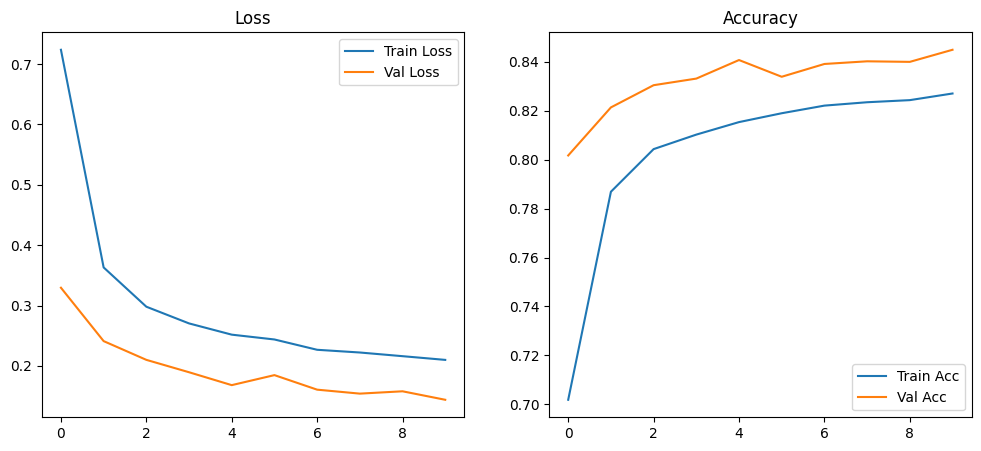

In [10]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

# Accuracy
plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.show()

In [11]:
os.makedirs("../models", exist_ok=True)
torch.save(model.state_dict(), "../models/asl_model.pth")
print("Model saved to ../models/asl_model.pth")

Model saved to ../models/asl_model.pth
